# VN30 Time Series Prediction with TensorFlow
This notebook loads VN30 stock data, lets you pick a ticker, trains Linear, NLinear, DLinear models, and plots forecasts.
# Chạy lần lượt từng cell , thay ticket ở cell cuôi để thay mã stock.

In [310]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

DATA_DIR = "./stock_data_vn30_480days"
TIME_COL = "time"
PRICE_COL = "close"
PRED_LEN = 7
SEQ_LENS = [7,30,180,360]


In [311]:
def load_data(ticker):
    # Tìm file có tên chứa ticker, ví dụ: ACB_480days_daily.csv
    files = os.listdir(DATA_DIR)
    match = None
    for f in files:
        if ticker.upper() in f.upper() and f.endswith(".csv"):
            match = os.path.join(DATA_DIR, f)
            break
    if match is None:
        raise FileNotFoundError(f"Không tìm thấy file cho ticker {ticker} trong folder {DATA_DIR}")

    df = pd.read_csv(match)

    # Chuẩn hoá tên cột
    if TIME_COL not in df.columns:
        # tự đoán cột thời gian
        for c in ["time","date","Date","datetime"]:
            if c in df.columns:
                df.rename(columns={c: TIME_COL}, inplace=True)
                break

    if PRICE_COL not in df.columns:
        # tự đoán cột giá
        for c in ["close","Close","close_price","adj_close"]:
            if c in df.columns:
                df.rename(columns={c: PRICE_COL}, inplace=True)
                break

    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df



In [312]:

def create_sequences(series, seq_len, pred_len):
    X, Y = [], []
    for i in range(len(series)-seq_len-pred_len+1):
        X.append(series[i:i+seq_len])
        Y.append(series[i+seq_len:i+seq_len+pred_len])
    return np.array(X), np.array(Y)


In [313]:

class LinearTF(tf.keras.Model):
    def __init__(self, seq_len, pred_len):
        super().__init__()
        self.d = tf.keras.layers.Dense(pred_len)
    def call(self, x):
        return self.d(x)

class NLinearTF(tf.keras.Model):
    def __init__(self, seq_len, pred_len):
        super().__init__()
        self.d = tf.keras.layers.Dense(pred_len)
    def call(self, x):
        last = x[:,-1:]
        x_norm = x - last
        pn = self.d(x_norm)
        return pn + last

class DLinearTF(tf.keras.Model):
    def __init__(self, seq_len, pred_len, ma=5):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(pred_len)
        self.d2 = tf.keras.layers.Dense(pred_len)
        kernel = tf.ones((ma,1,1))/ma
        self.kernel = tf.Variable(kernel, trainable=False)
    def decompose(self, x):
        xe = tf.expand_dims(x,2)
        trend = tf.nn.conv1d(xe, self.kernel, 1, "SAME")
        trend = tf.squeeze(trend,2)
        seas = x - trend
        return trend, seas
    def call(self, x):
        t,s = self.decompose(x)
        return self.d1(t)+self.d2(s)


In [314]:

def train_model(model, Xtr, Ytr, Xval, Yval):
    model.compile(optimizer='adam', loss='mse')
    model.fit(Xtr, Ytr, validation_data=(Xval,Yval), epochs=40, verbose=0)
    return model


In [315]:
def run_seq(prices, seq_len):
    # Tạo sequence train: dùng toàn bộ dữ liệu trừ 7 ngày cuối
    train_prices = prices[:-200]
    test_prices  = prices[-(seq_len+200):]   # seq để predict + 7 ngày thực

    # train sequences
    X_train, Y_train = create_sequences(train_prices, seq_len, PRED_LEN)

    # test sequence (1 mẫu duy nhất)
    X_test = test_prices[:seq_len].reshape(1, seq_len)
    Y_test = test_prices[seq_len:].reshape(1, PRED_LEN)

    # scale theo train
    sx = StandardScaler()
    sy = StandardScaler()
    X_train_s = sx.fit_transform(X_train)
    Y_train_s = sy.fit_transform(Y_train)

    X_test_s = sx.transform(X_test)

    # Train 3 models
    m1 = LinearTF(seq_len, PRED_LEN)
    m2 = NLinearTF(seq_len, PRED_LEN)
    m3 = DLinearTF(seq_len, PRED_LEN)

    m1.compile(loss="mse", optimizer="adam")
    m2.compile(loss="mse", optimizer="adam")
    m3.compile(loss="mse", optimizer="adam")

    m1.fit(X_train_s, Y_train_s, epochs=50, verbose=0)
    m2.fit(X_train_s, Y_train_s, epochs=50, verbose=0)
    m3.fit(X_train_s, Y_train_s, epochs=50, verbose=0)

    # Predict
    p1 = sy.inverse_transform(m1.predict(X_test_s))
    p2 = sy.inverse_transform(m2.predict(X_test_s))
    p3 = sy.inverse_transform(m3.predict(X_test_s))

    # return 7 ngày thực tế + 3 đường dự đoán
    return Y_test.flatten(), p1.flatten(), p2.flatten(), p3.flatten()


In [316]:
def run_recursive_forecast(prices, seq_len):
    """
    Perform recursive forecasting for the last 200 days using trained models.

    Args:
        prices (np.ndarray): Array of stock prices.
        seq_len (int): Sequence length for the input data.

    Returns:
        dict: A dictionary containing predictions for each model.
    """
    # Prepare data for forecasting
    train_prices = prices[:-200]
    test_prices = prices[-(seq_len + 200):]

    # Create sequences
    X_train, Y_train = create_sequences(train_prices, seq_len, PRED_LEN)
    X_test = test_prices[:seq_len].reshape(1, seq_len)

    # Scale data
    sx = StandardScaler()
    sy = StandardScaler()
    X_train_s = sx.fit_transform(X_train)
    Y_train_s = sy.fit_transform(Y_train)
    X_test_s = sx.transform(X_test)

    # Train models
    models = {
        "LinearTF": LinearTF(seq_len, PRED_LEN),
        "NLinearTF": NLinearTF(seq_len, PRED_LEN),
        "DLinearTF": DLinearTF(seq_len, PRED_LEN)
    }

    for model in models.values():
        model.compile(optimizer="adam", loss="mse")
        model.fit(X_train_s, Y_train_s, epochs=50, verbose=0)

    # Perform recursive forecasting
    predictions = {name: [] for name in models.keys()}
    current_input = test_prices[:seq_len]  # Start with the first sequence from actual prices

    for i in range(200 // PRED_LEN):
        for name, model in models.items():
            # Scale the current input
            current_input_scaled = sx.transform(current_input.reshape(1, -1))

            # Predict the next 7 days
            pred = model.predict(current_input_scaled)
            pred_rescaled = sy.inverse_transform(pred)
            predictions[name].extend(pred_rescaled.flatten())

            # Update the current input: shift by 7 days and append the new predictions
            current_input = np.roll(current_input, -PRED_LEN)
            current_input[-PRED_LEN:] = test_prices[seq_len + i * PRED_LEN: seq_len + (i + 1) * PRED_LEN]

    return predictions


=== Recursive Forecasting for seq_len=7 ===

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 

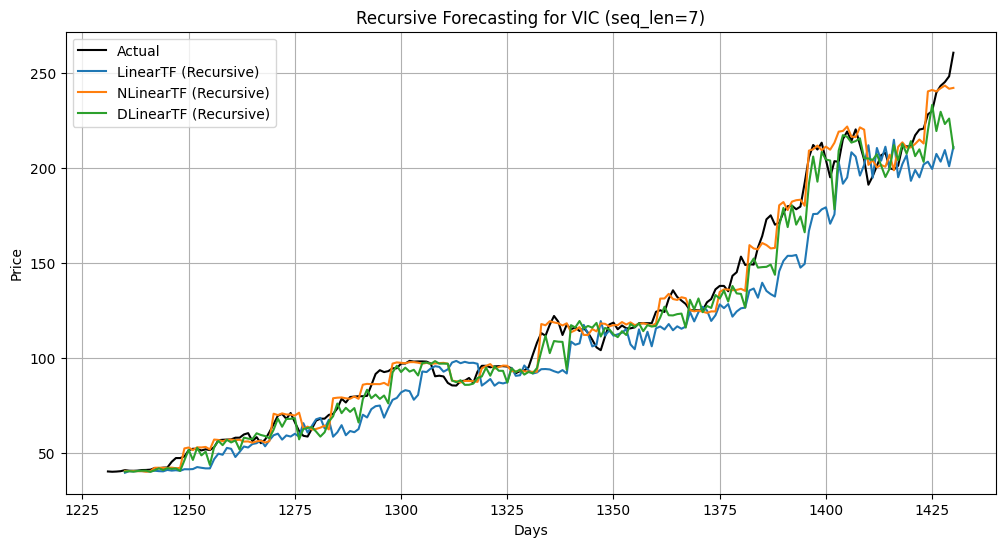


=== Recursive Forecasting for seq_len=30 ===

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1

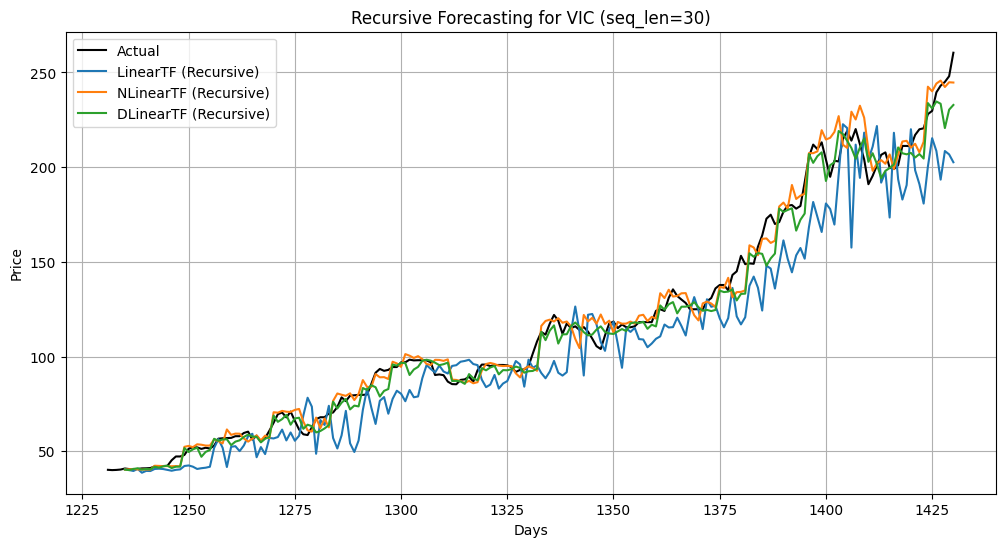


=== Recursive Forecasting for seq_len=180 ===

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/

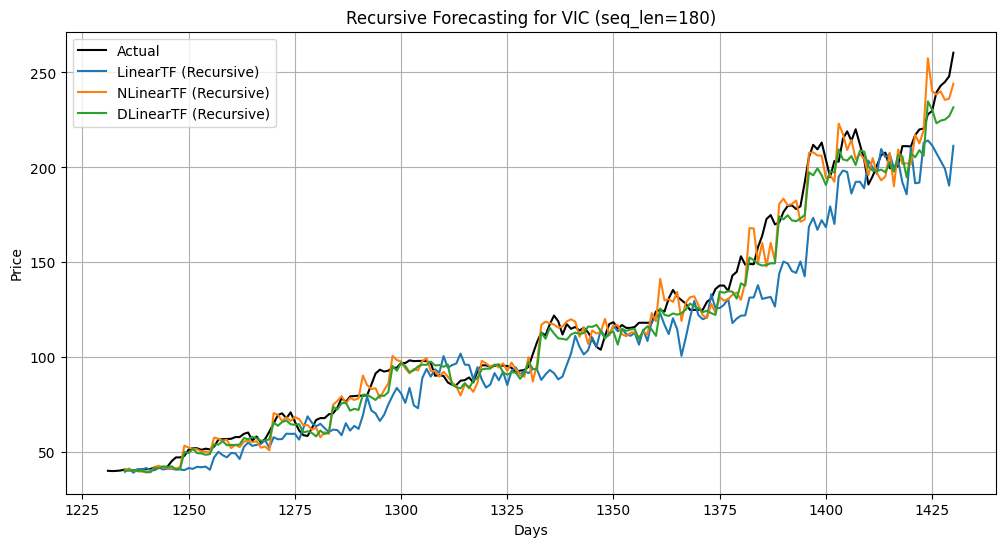


=== Recursive Forecasting for seq_len=360 ===

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/

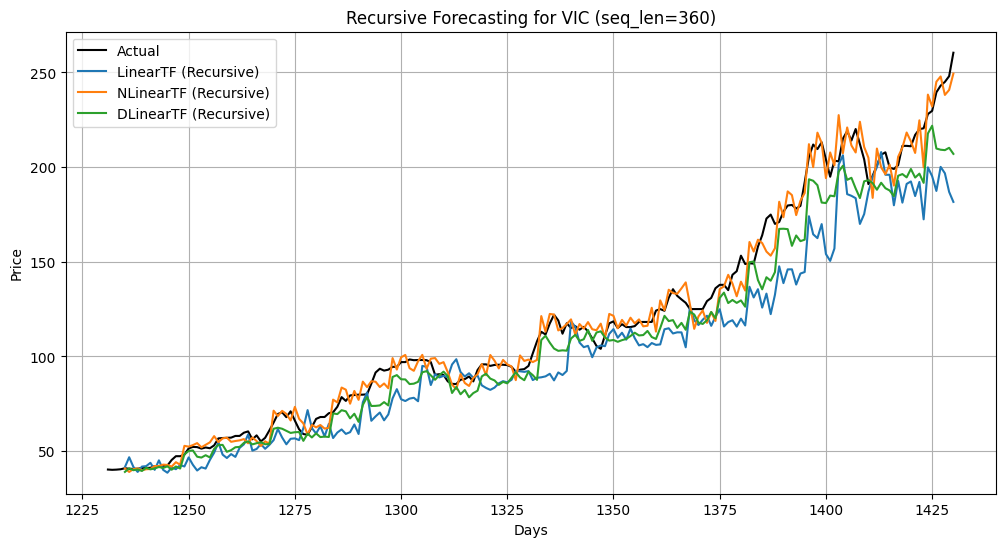

In [317]:
ticker = "VIC"
df = load_data(ticker)
prices = df[PRICE_COL].values.astype(float)

for seq_len in SEQ_LENS:
    print(f"\n=== Recursive Forecasting for seq_len={seq_len} ===\n")

    if len(prices) < seq_len + 200:
        print(f"⚠️ Skipping seq_len={seq_len} due to insufficient data ({len(prices)} < {seq_len + 200})")
        continue

    # Perform recursive forecasting
    predictions = run_recursive_forecast(prices, seq_len)

    # Plot the results
    plt.figure(figsize=(12, 6))
    days = np.arange(len(prices) - 200, len(prices))

    # Plot actual prices for the prediction period
    plt.plot(days, prices[-200:], label="Actual", color="black")

    for name, preds in predictions.items():
        # Ensure days and predictions have the same length
        valid_days = days[-len(preds):]
        plt.plot(valid_days, preds, label=f"{name} (Recursive)")

    plt.title(f"Recursive Forecasting for {ticker} (seq_len={seq_len})")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

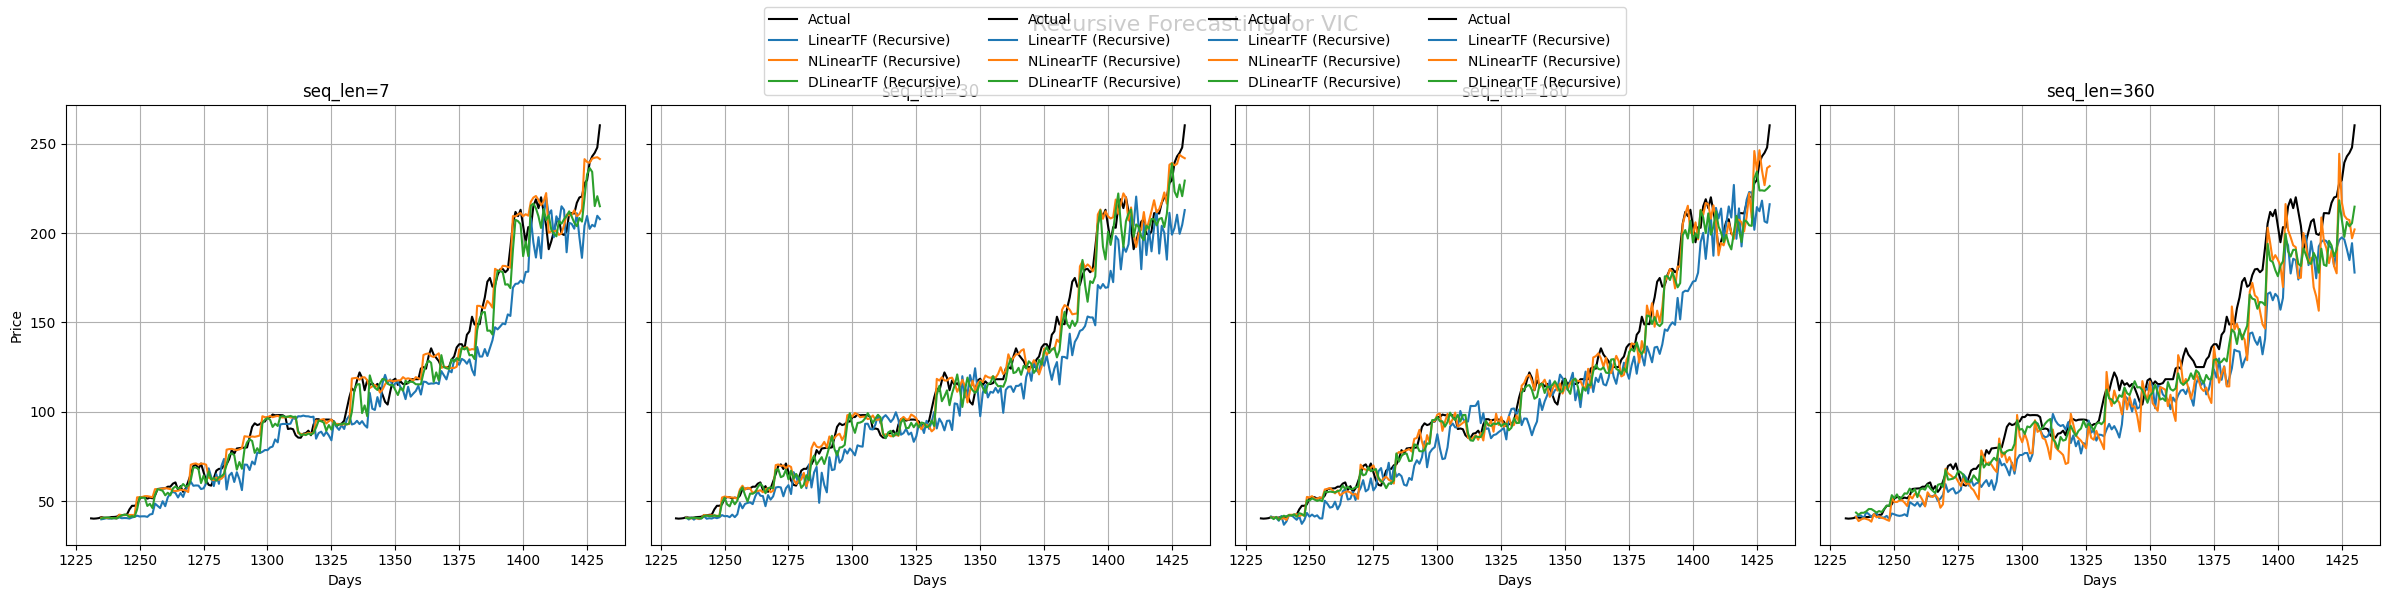

In [318]:
# Plot all 4 subplots in one figure
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

for idx, seq_len in enumerate(SEQ_LENS):
    if len(prices) < seq_len + 200:
        print(f"⚠️ Skipping seq_len={seq_len} due to insufficient data ({len(prices)} < {seq_len + 200})")
        continue

    # Perform recursive forecasting
    predictions = run_recursive_forecast(prices, seq_len)

    # Plot the results in the corresponding subplot
    days = np.arange(len(prices) - 200, len(prices))
    axes[idx].plot(days, prices[-200:], label="Actual", color="black")

    for name, preds in predictions.items():
        valid_days = days[-len(preds):]
        axes[idx].plot(valid_days, preds, label=f"{name} (Recursive)")

    axes[idx].set_title(f"seq_len={seq_len}")
    axes[idx].set_xlabel("Days")
    axes[idx].grid(True)

axes[0].set_ylabel("Price")
fig.suptitle(f"Recursive Forecasting for {ticker}", fontsize=16)
fig.legend(loc="upper center", ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()